# Binary classifiers

Apziva project #4: "MonReader"<br>
2023 08 03

__Summary:__
* In this notebook, the following ML models are run: __L2, Random Forest, SVM__.
* All models include __scaling and PCA__.
* All models include __grid-searches__ on typical hyperparameters, including the PCA n as a hyperparameter.
* All models use 5-fold __cross-validation__.
* All models are run on __each combination of image preprocessing__: Inception/MobileNet x Squeeze/Crop.
* Alltogether this leads to 4 x 3 model runs, i.e. 12 F1 values are calculated to find the __best out of 12 models__.

## TOC: <a class="anchor" id="TOC"></a>
* [Utilities](#Utilities)
* [General settings](#GeneralSetting)
* [Classifiers](#Classifiers)    
    * [L2](#L2)    
    * [Random forest](#RandomForest)  
    * [SVM](#SVM)  
* [Main loop](#MainLoop)     

## Utilities <a class="anchor" id="Utilities"></a>
[TOC](#TOC)

In [1]:
# own libraries
import Utilities as u
import MachineLearning as ml

# activate changes in libraries
import importlib
importlib.reload(u)
importlib.reload(ml)

# aliases
from Utilities import TypeChecker as t
from Utilities import PrintAlias as p

## General settings <a class="anchor" id="GeneralSetting"></a>
[TOC](#TOC)

In [2]:
# constants

# general
cfltRandomSeed = 42 # any number

# files
cstrDownloadRoot =         "../../OutsideRepository/ImagesRaw/"
cstrImagePreparationRoot = "../../OutsideRepository/ImagesProcessed/"

cdintSquareSides =            {"Inception":299,"MobileNet":224}

clstrTransferLearningModels = ["Inception","MobileNet"]
clstrSquaringStrategies     = ["Squeeze","Crop"]

clstrDownloadDatasets =       ["training","testing"]
clstrDownloadClasses  =       ["flip","notflip"]

clstrMLModels =               ["L2","Random Forest","SVM"]

## Classifiers <a class="anchor" id="Classifiers"></a>
[TOC](#TOC)

### L2 <a class="anchor" id="L2"></a>
[TOC](#TOC)

In [3]:
import numpy as np
np.random.seed(cfltRandomSeed)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

def L2(X_train, y_train, X_test, y_test):
    '''
    Runs an L2 classifier (ridge regression).
    
    When       Who What
    2023 08 03 dh  Created
    '''

    # pipeline
    objPipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('ridge', RidgeClassifier())
    ])

    # grid-search
    np.random.seed(cfltRandomSeed)
    objParameterGrid = {
        'pca__n_components': [5,20, 50, 100, 200, 400],
        'ridge__alpha': [0.01,0.1,1,10,100]
    }
    objGridSearch = GridSearchCV(objPipeline, objParameterGrid, cv=5, scoring='f1')
    
    # train model
    u.StopWatch()
    objGridSearch.fit(X_train, y_train)
    fltSecondsTraining = u.StopWatch("seconds",blnAsFloat=True)
    
    # best model
    objBestModel = objGridSearch.best_estimator_
    intBestPcaNComponents = objBestModel.named_steps['pca'].n_components
    fltBestRidgeAlpha = objBestModel.named_steps['ridge'].alpha
    strHyperparameters = f"PCA n = {intBestPcaNComponents}; ridge alpha = {fltBestRidgeAlpha}"

    # predict
    u.StopWatch()
    y_pred = objBestModel.predict(X_test)
    fltSecondsPredicting = u.StopWatch("seconds",blnAsFloat=True) / len(y_pred)
    
    # calculate metric
    fltF1 = f1_score(y_test, y_pred)

    # finalize
    return {
        "Seconds training":fltSecondsTraining,
        "Seconds predicting":fltSecondsPredicting,
        "Best model": objBestModel,
        "Hyperparameters": strHyperparameters,
        "F1":fltF1
    }

### Random forest <a class="anchor" id="RandomForest"></a>
[TOC](#TOC)

In [4]:
import numpy as np
np.random.seed(cfltRandomSeed)
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

def RandomForest(X_train, y_train, X_test, y_test):
    '''
    Runs an random forest classifier.
    
    When       Who What
    2023 08 03 dh  Created
    '''

    # pipeline
    objPipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('rf', RandomForestClassifier())
    ])

    # grid search
    np.random.seed(cfltRandomSeed)
    objParameterGrid = {
        'pca__n_components': [5,20, 50, 100, 200, 400],
        'rf__n_estimators': [100,200,300],
        'rf__max_depth': [10,20,30]
    }
    objGridSearch = GridSearchCV(objPipeline, objParameterGrid, cv=5, scoring='f1')

    # training
    u.StopWatch()
    objGridSearch.fit(X_train, y_train)
    fltSecondsTraining = u.StopWatch("seconds",blnAsFloat=True)    

    # best model
    objBestModel = objGridSearch.best_estimator_
    intBestPcaNComponents = objBestModel.named_steps['pca'].n_components
    intBestRFNestimators = objBestModel.named_steps['rf'].n_estimators
    intBestRFMaxDepth = objBestModel.named_steps['rf'].max_depth
    strHyperparameters = f"PCA n = {intBestPcaNComponents}; tree count = {intBestRFNestimators}; depth = {intBestRFMaxDepth}"

    # predict
    u.StopWatch()
    y_pred = objBestModel.predict(X_test)
    fltSecondsPredicting = u.StopWatch("seconds",blnAsFloat=True) / len(y_pred)    

    # metric: F1
    fltF1 = f1_score(y_test, y_pred)

    # finalize
    return {
        "Seconds training":fltSecondsTraining,
        "Seconds predicting":fltSecondsPredicting,
        "Best model": objBestModel,
        "Hyperparameters": strHyperparameters,
        "F1":fltF1
    }

### SVM <a class="anchor" id="SVM"></a>
[TOC](#TOC)

In [5]:
import numpy as np
np.random.seed(cfltRandomSeed)
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

def SVM(X_train, y_train, X_test, y_test):
    '''
    Runs an SVM classifier.
    
    When       Who What
    2023 08 03 dh  Created
    '''

    # pipeline
    objPipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('svm', SVC())
    ])

    # grid
    np.random.seed(cfltRandomSeed)
    objParameterGrid = {
        'pca__n_components': [5,20, 50, 100, 200, 400],
        'svm__C': [0.2,1,5],
        'svm__gamma': [0.01,0.1,1]
    }
    objGridSearch = GridSearchCV(objPipeline, objParameterGrid, scoring='f1', cv=5)
    
    # training
    u.StopWatch()
    objGridSearch.fit(X_train, y_train)
    fltSecondsTraining = u.StopWatch("seconds",blnAsFloat=True)    
    objBestModel = objGridSearch.best_estimator_
    intBestPcaNComponents = objBestModel.named_steps['pca'].n_components
    fltBestSvmC = objBestModel.named_steps['svm'].C
    fltBestSvmGamma = objBestModel.named_steps['svm'].gamma    
    strHyperparameters = f"PCA n = {intBestPcaNComponents}; C= {fltBestSvmC}; gamma = {fltBestSvmGamma}"
    
    # predict
    u.StopWatch()
    y_pred = objBestModel.predict(X_test)
    fltSecondsPredicting = u.StopWatch("seconds",blnAsFloat=True) / len(y_pred)    
    
    # metric F1
    fltF1 = f1_score(y_test,y_pred)
    
    # finalize
    return {
        "Seconds training":fltSecondsTraining,
        "Seconds predicting":fltSecondsPredicting,
        "Best model": objBestModel,
        "Hyperparameters": strHyperparameters,
        "F1":fltF1
    }

## Main loop <a class="anchor" id="MainLoop"></a>
[TOC](#TOC)

In [10]:
import pandas as pd

# init
dfrAllResults = pd.DataFrame()
intAllModelRuns = len(clstrTransferLearningModels) * len(clstrSquaringStrategies) * len(clstrMLModels)
intCurrModelRuns = 0

# loop through...
# - transfer-learning models
# - squaring strategies
# - ML models
for strTLModel in clstrTransferLearningModels[:1]:
    for strSquaringStrategy in clstrSquaringStrategies[:1]:
        
        # init
        p(f"• Running classifiers for {strTLModel} - {strSquaringStrategy}...")
        p()
        
        # root of all 4 pickle files
        strPickleFileRoot = f"../data/processed/{strTLModel}/{strSquaringStrategy}/"
        
        # 4 datasets
        X_train = u.FromDisk(f"{strPickleFileRoot}X_train.p",strType="")  
        y_train = u.FromDisk(f"{strPickleFileRoot}y_train.p",strType="")  
        X_test  = u.FromDisk(f"{strPickleFileRoot}X_test.p", strType="")  
        y_test  = u.FromDisk(f"{strPickleFileRoot}y_test.p", strType="")  
        
        p("   Dataset shapes:".upper())
        p("   Train: X", X_train.shape)        
        p("          y", y_train.shape)        
        p("   Test:  X", X_test.shape)        
        p("          y", y_test.shape)
        p()
        
        # loop through ML models
        for strMLModel in clstrMLModels[:1]:
            print(f"   • {round(100*intCurrModelRuns/intAllModelRuns)}% done so far, running binary classifier '{strMLModel}' now...", end="")  
            strMLModelAsFunctionName = strMLModel.replace(" ", "")
            exec(f"dvarResults = {strMLModelAsFunctionName}(X_train, y_train, X_test, y_test)") 
            dvarResults["TL model"]=strTLModel
            dvarResults["Squaring"]=strSquaringStrategy
            dvarResults["ML model"]=strMLModel            
            p(f" F1 = {round(100*dvarResults['F1'],1)}%")
            dfrAllResults = dfrAllResults.append(dvarResults, ignore_index=True)
            intCurrModelRuns += 1
        p()            

# sort results
dfrAllResults = dfrAllResults.sort_values(by='F1', ascending=False)
dfrAllResults = u.DataFrameColumnMoved (dfrAllResults, "ML model", intTargetPosition = 0)
dfrAllResults = u.DataFrameColumnMoved (dfrAllResults, "Squaring", intTargetPosition = 0)
dfrAllResults = u.DataFrameColumnMoved (dfrAllResults, "TL model", intTargetPosition = 0)
dfrAllResults["Seconds training"]   =   dfrAllResults["Seconds training"].round(2)
dfrAllResults["Seconds predicting"] = dfrAllResults["Seconds predicting"].round(6)
dfrAllResults["F1"]                 =                 dfrAllResults["F1"].round(3)

# save
u.ToDisk(dfrAllResults,strType="model")

# feedback
p("All results".upper())
pd.set_option('display.max_colwidth', 700)
u.DisplayDataFrame(dfrAllResults) 
pd.reset_option('display.max_colwidth')

• Running classifiers for Inception - Squeeze...

   DATASET SHAPES:
   Train: X (2392, 2048)
          y (2392,)
   Test:  X (597, 2048)
          y (597,)

   • 0% done so far, running binary classifier 'L2' now... F1 = 98.1%

ALL RESULTS


,TL model,Squaring,ML model,Seconds training,Seconds predicting,Best model,Hyperparameters,F1
0,Inception,Squeeze,L2,208.13,0.000032,"(StandardScaler(), PCA(n_components=400), RidgeClassifier(alpha=100))",PCA n = 400; ridge alpha = 100,0.981


__Warning:__
* The following dataframe output is an image!
* The cell above ("Main loop") must be run again.
* I takes about 3.5 hours.

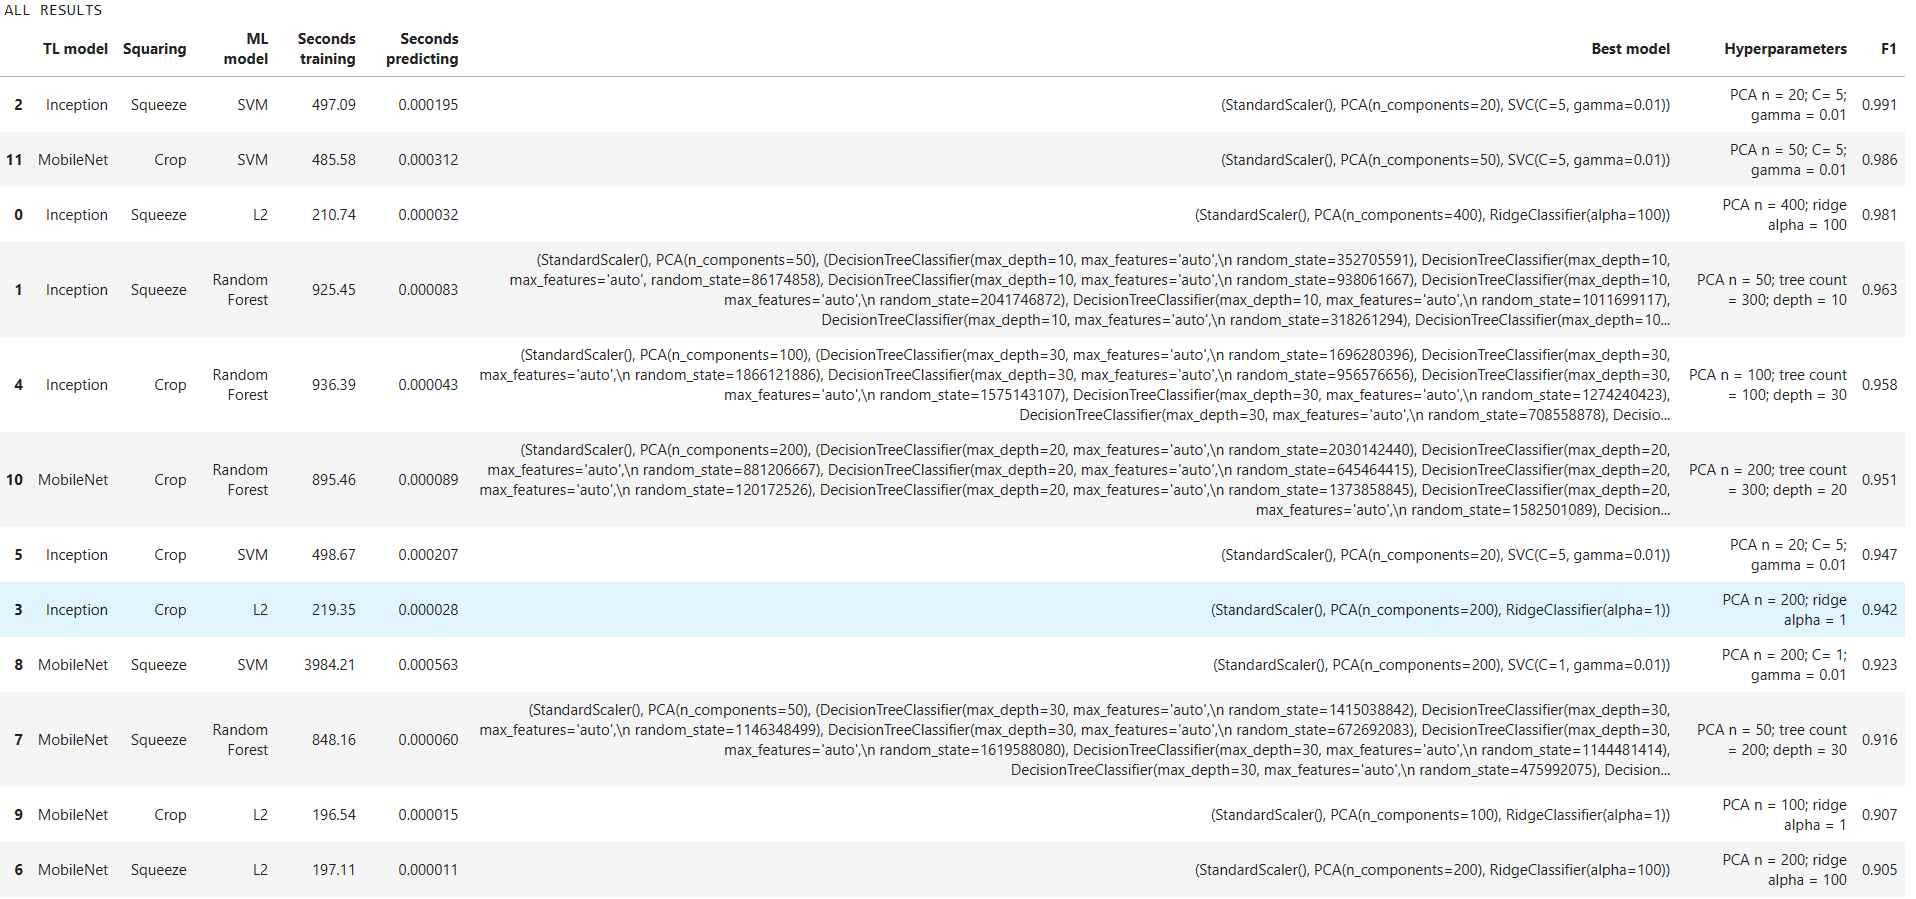

__Conclusions:__
* The best predictions are achieved using the following techniques and hyperparameters:
    * Techniques:
        * __Inception__ as the TL model.
        * __Squeezing__ to get squares of size 299 x 299.
        * __SVM__ as the ML model.
    * Hyperparameters:
        * PCA n = __20__
        * C = __5__
        * gamma = __0.01__
    * Further improvements:
        * The best C and gamma are at the __edge of the hyperparameter ranges__, thus there could be further improvement.
        * On the other hand, the result is already __good enough__.
* The model achieves an __F1 score of 99.1%__.
* Computational time:
    * __Training__: With __8 minutes__, the training time for the SVM is medium.
    * __Prediction__: The prediction time of __0.2 ms__ is good.